In [1]:
from transformers import AutoTokenizer
from transformers.utils import logging as hf_logging
hf_logging.set_verbosity_error()
from transformers.utils import logging as hf_logging
hf_logging.set_verbosity_error()
tok = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", use_fast=False, src_lang="eng_Latn")

tok.eos_token_id

/home/dev371/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


2

In [2]:
#!pip install -q librosa soundfile transformers
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import os, numpy as np, tensorflow as tf, librosa, soundfile as sf
from IPython.display import Audio, display
from transformers import AutoTokenizer

# لاگ‌های اضافی کمتر
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
for gpu in tf.config.list_physical_devices("GPU"):
    try: tf.config.experimental.set_memory_growth(gpu, True)
    except: pass


2025-10-23 17:59:28.908185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761229768.920137  689520 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761229768.923796  689520 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761229768.933656  689520 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761229768.933665  689520 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761229768.933666  689520 computation_placer.cc:177] computation placer alr

In [3]:
from MyTTSModel import TransformerTTS  # همان فایلی که مدل TTS را نوشتی
import os

# پارامترها باید با آموزش هم‌خوانی داشته باشند
SR          = 16000
N_FFT       = 1024
HOP         = 256
WIN         = 1024
N_MELS      = 80
FMIN        = 0.0
FMAX        = 8000.0
MAX_SRC_LEN = 256
MAX_MEL_LEN = 2000  # سقف منطقی برای تولید

# توکنایزر NLLB (فعلاً انگلیسی)
tok = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", use_fast=False, src_lang="eng_Latn")
PAD_ID = tok.pad_token_id

# ساخت/لود مدل با preset یکپارچه
from TTSConfig import get_model_preset, GreedyDefaults, compute_greedy_params
PRESET = "normal"
mcfg = get_model_preset(PRESET)
core = TransformerTTS(
    num_layers=mcfg.num_layers, d_model=mcfg.d_model, num_heads=mcfg.num_heads, dff=mcfg.dff,
    input_vocab_size=len(tok), n_mels=N_MELS,
    dropout_rate=mcfg.dropout_rate, pad_id=PAD_ID,
    use_prenet=mcfg.use_prenet, prenet_drop=mcfg.prenet_drop,
    droppath_rate=mcfg.droppath_rate, cross_win=mcfg.cross_win
)

core.build_for_load(max_src_len=MAX_SRC_LEN, max_tgt_len=MAX_MEL_LEN)
# وزن‌های آموزش‌داده‌شده‌ات (اولویت با EMA)
os.makedirs("checkpoints", exist_ok=True)
core_path = "checkpoints/tts_core_ema_last.weights.h5"
if not os.path.exists(core_path):
    core_path = "checkpoints/tts_core_last.weights.h5"

if os.path.exists(core_path):
    try:
        core.load_weights(core_path)
        print("✅ Weights loaded.")
    except Exception as e:
        print("⚠️ Strict load failed:", e)
        try:
            core.load_weights(core_path, skip_mismatch=True)
            print("✅ Weights loaded (skip_mismatch).")
        except Exception as e2:
            print("⚠️ Fallback load failed:", e2)
else:
    print("⚠️ Checkpoint not found:", core_path)


/home/dev371/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
I0000 00:00:1761229773.155076  689520 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22279 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:4e:00.0, compute capability: 8.9


Model: "TransformerTTS"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Encoder)               │ ?                      │   156,395,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ tokpos                     │ ?                      │   131,176,448 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dropout (Dropout)          │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_0 (EncoderLayer)     │ ?                      │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_1 (EncoderLayer)     │ ?                      │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_2 (EncoderLayer)     │ ?                      │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_3 (EncoderLayer)     │ ?                      │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_4 (EncoderLayer)     │ ?                      │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_5 (EncoderLayer)     │ ?                      │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_6 (EncoderLayer)     │ ?                      │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_7 (EncoderLayer)     │ ?                      │     3,152,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (DecoderTTS)            │ ?                      │    33,850,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ melpos                     │ ?                      │       218,112 │
│ (MelPositionalProjection)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ dropout (Dropout)          │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_0 (DecoderLayer)     │ ?                      │     4,204,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_1 (DecoderLayer)     │ ?                      │     4,204,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_2 (DecoderLayer)     │ ?                      │     4,204,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_3 (DecoderLayer)     │ ?                      │     4,204,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_4 (DecoderLayer)     │ ?                      │     4,204,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_5 (DecoderLayer)     │ ?                      │     4,204,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_6 (DecoderLayer)     │ ?                      │     4,204,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_7 (DecoderLayer)     │ ?                      │     4,204,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mel_head (Dense)                │ (None, 2000, 80)       │        41,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ stop_head (Dense)               │ (None, 2000, 1)        │           51

 Total params: 194,639,921 (742.49 MB)

 Trainable params: 194,635,665 (742.48 MB)

 Non-trainable params: 4,256 (16.62 KB)

✅ Weights loaded.


In [4]:
# ---------- کمکـی‌ها برای برگرداندن mel_norm[-1,1] به موج ----------
def db_to_power(db): return tf.pow(10.0, db / 10.0)

def denorm_mel(mel_norm):
    mel01  = (mel_norm + 1.0) * 0.5        # [-1,1] -> [0,1]
    mel_db = mel01 * 100.0 - 100.0         # -> [-100, 0] dB
    return db_to_power(mel_db)             # -> power

def mel_to_linear_power(mel_power, sr=SR, n_fft=N_FFT, n_mels=N_MELS, fmin=FMIN, fmax=FMAX):
    mel_mat = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=n_mels,
        num_spectrogram_bins=n_fft // 2 + 1,
        sample_rate=float(sr),
        lower_edge_hertz=float(fmin),
        upper_edge_hertz=float(fmax),
        dtype=tf.float32
    )  # (n_fft//2+1, n_mels)
    mel_pinv = tf.linalg.pinv(mel_mat)               # (n_mels, n_fft//2+1)
    linear_power = tf.matmul(mel_power, mel_pinv)    # (T, n_fft//2+1)
    return tf.maximum(linear_power, 1e-10)

def griffin_lim_from_mag(mag, n_fft=N_FFT, hop=HOP, win=WIN, n_iter=60):
    mag = tf.cast(mag, tf.float32)

    # --- init random phase (بدون 1j) ---
    phases = tf.random.uniform(tf.shape(mag), 0.0, 2.0*np.pi, dtype=tf.float32)
    angles = tf.complex(tf.cos(phases), tf.sin(phases))            # (T, n_fft//2+1) complex64
    S = tf.cast(mag, tf.complex64) * angles

    def _stft(w):
        return tf.signal.stft(w, frame_length=win, frame_step=hop,
                              fft_length=n_fft, window_fn=tf.signal.hann_window)
    def _istft(S_):
        return tf.signal.inverse_stft(S_, frame_length=win, frame_step=hop,
                                      window_fn=tf.signal.hann_window)

    for _ in range(n_iter):
        wav = _istft(S)
        S_est = _stft(wav)
        ang = tf.math.angle(S_est)                                 # float32
        phase = tf.complex(tf.cos(ang), tf.sin(ang))               # complex64
        S = tf.cast(mag, tf.complex64) * phase

    wav = _istft(S)
    wav = wav / (tf.reduce_max(tf.abs(wav)) + 1e-6)                # [-1,1]
    return tf.squeeze(wav)


def mel_to_wav_griffinlim(mel_norm, n_iter=60):
    mel_norm = tf.clip_by_value(mel_norm, -1.0, 1.0)
    mel_power = denorm_mel(mel_norm)
    linear_power = mel_to_linear_power(mel_power)
    mag = tf.sqrt(tf.maximum(linear_power, 1e-10))
    return griffin_lim_from_mag(mag, n_iter=n_iter)

# ---------- مدل و توکنایزر ----------
# فرض: core همون TransformerTTS شماست که build شده و وزن‌هاش لود شدن
# core.load_weights("checkpoints/tts_core_best.weights.h5")

tok = AutoTokenizer.from_pretrained("facebook/nllb-200-distilled-600M", use_fast=False, src_lang="eng_Latn")

def tokenize_texts(texts, tok, max_len=256, pad_id=1):
    ids = [tok.encode(t, add_special_tokens=True, src_lang="eng_Latn")[:max_len] for t in texts]
    lens = [len(x) for x in ids]
    ids_pad = tf.keras.preprocessing.sequence.pad_sequences(ids, maxlen=max_len, padding="post", value=pad_id)
    return tf.constant(ids_pad, tf.int32), tf.constant(lens, tf.int32)



# (اختیاری) ذخیره‌ی WAV روی دیسک
# tf.io.write_file("tts_out.wav", tf.audio.encode_wav(tf.expand_dims(wav, -1), sample_rate=SR))

In [5]:
# ---------- اینفرنس ----------
texts = ["Please use our dedicated channels for questions and discussion"]
enc_ids, lens = tokenize_texts(texts, tok, max_len=MAX_SRC_LEN, pad_id=PAD_ID)

# Adaptive greedy params from config
tok_len = int(lens.numpy()[0]) if hasattr(lens, 'numpy') else int(lens[0])
gdef = GreedyDefaults()
gparams = compute_greedy_params(tok_len, gdef)

# Generate
mel_hat, stop_probs = core.greedy_generate_fast(
    enc_ids,
    **gparams
)
# Report output duration
frames = int(mel_hat.shape[1])
print('Frames:', frames, 'Seconds:', frames/(SR/HOP))
mel_one = mel_hat[0].numpy()
wav = mel_to_wav_griffinlim(mel_one, n_iter=60)  # قبلاً 64 یا 60 بود
Audio(wav.numpy(), rate=SR)

/home/dev371/.local/lib/python3.10/site-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


gen step 50 stop~ 0.0676528737
gen step 100 stop~ 0.0870103166
gen step 150 stop~ 0.573919
gen step 200 stop~ 0.662617624
gen step 250 stop~ 0.789378524
gen step 300 stop~ 0.954387069
[stop @ step 310]
Frames: 310 Seconds: 4.96


I0000 00:00:1761229826.473568  689520 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x5c71395d34c0


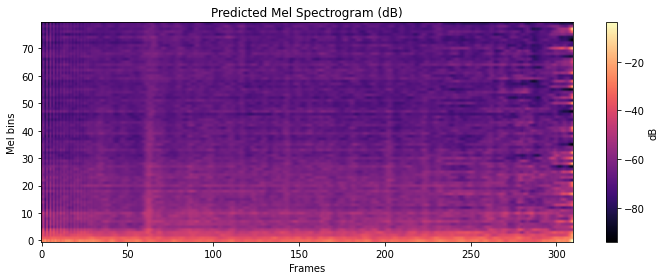

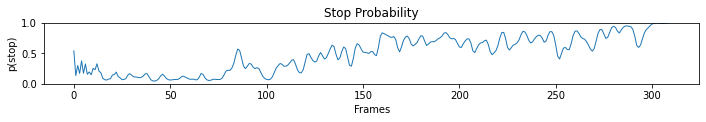

In [6]:
# ---------- Visualization: Mel spectrogram + Stop probability ----------
import matplotlib.pyplot as plt
import numpy as np

def mel_norm_to_db(m):
    """Convert normalized mel [-1,1] to dB [-100,0].
    """
    m = np.clip(m, -1.0, 1.0)
    return ((m + 1.0) * 0.5) * 100.0 - 100.0

# Plot mel in dB
mel_db = mel_norm_to_db(mel_one)
plt.figure(figsize=(10, 4))
plt.imshow(mel_db.T, origin='lower', aspect='auto', cmap='magma')
cbar = plt.colorbar(); cbar.set_label('dB')
plt.xlabel('Frames')
plt.ylabel('Mel bins')
plt.title('Predicted Mel Spectrogram (dB)')
plt.tight_layout()
plt.show()

# Plot stop probability over time (if available)
try:
    sp = stop_probs[0].numpy().squeeze()
    plt.figure(figsize=(10, 1.8))
    plt.plot(sp, linewidth=1.0)
    plt.ylim([0, 1])
    plt.xlabel('Frames')
    plt.ylabel('p(stop)')
    plt.title('Stop Probability')
    plt.tight_layout()
    plt.show()
except Exception:
    pass
